In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6


In [3]:
dataset = pd.read_csv("sales_per_day.csv", index_col=0)
dataset['transaction_date']=pd.to_datetime(dataset['transaction_date'], infer_datetime_format=True)
indexedDataset=dataset.set_index(['transaction_date'])

In [4]:
from datetime import datetime
indexedDataset.head(5)

,sales
transaction_date,
2018-08-31,431.91
2018-09-01,2340.61
2018-09-02,2573.14
2018-09-03,1108.01
2018-09-04,962.89


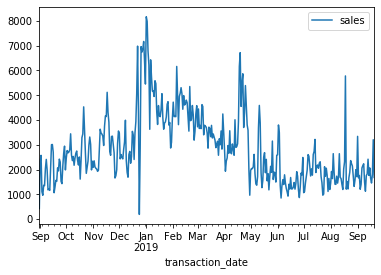

In [5]:
indexedDataset.plot()

### Determining rolling statistics to check stationarity of the data 
#### ('2018-08-31' to '2019-09-20' range)

In [6]:
rolmean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean, rolstd)

                        sales
transaction_date             
2018-08-31                NaN
2018-09-01                NaN
2018-09-02                NaN
2018-09-03                NaN
2018-09-04                NaN
2018-09-05                NaN
2018-09-06                NaN
2018-09-07                NaN
2018-09-08                NaN
2018-09-09                NaN
2018-09-10                NaN
2018-09-11        1579.605000
2018-09-12        1640.300833
2018-09-13        1614.335000
2018-09-14        1650.295833
2018-09-15        1808.905833
2018-09-16        1953.657500
2018-09-17        1928.581667
2018-09-18        1923.714167
2018-09-19        1883.569167
2018-09-20        1809.775000
2018-09-21        1817.641667
2018-09-22        1881.413333
2018-09-23        1982.485000
2018-09-24        2077.795833
2018-09-25        2036.075833
2018-09-26        1904.979167
2018-09-27        1832.411667
2018-09-28        1828.330000
2018-09-29        1984.988333
...                       ...
2019-08-22

### Plot rolling statistics

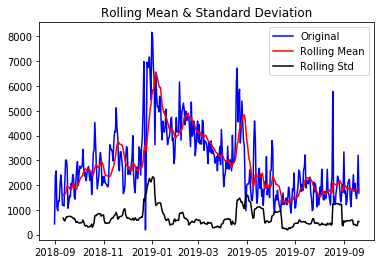

In [7]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Performing Dickey-Fuller test

In [8]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['sales'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistics                 -2.179690
p-value                          0.213699
#Lags Used                      13.000000
Number of Observations Used    372.000000
Critical Value (1%)             -3.448052
Critical Value (5%)             -2.869341
Critical Value (10%)            -2.570926
dtype: float64


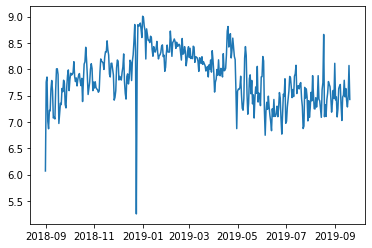

In [9]:
# Dickey-Fuller test results
#Estimating Trend

indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)


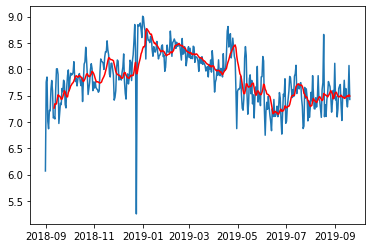

In [10]:
#Calculating moving average 
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
#Outcome: mean is not stationary

In [11]:
#Getting difference between sales and moving average (data transformation) to obtain stationary data.
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NaN Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)


,sales
transaction_date,
2018-09-11,-0.165938
2018-09-12,-0.289254
2018-09-13,0.281560
2018-09-14,0.661254
2018-09-15,0.580150
2018-09-16,0.385068
2018-09-17,-0.524107
2018-09-18,-0.326704
2018-09-19,-0.115182


In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
                
#Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

#Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#Perform Dickey-Fuller Test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    
    print(dfoutput)


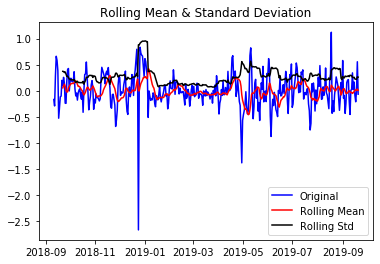

Results of Dickey-Fuller Test:
Test Statistics                 -5.419712
p-value                          0.000003
#Lags Used                      13.000000
Number of Observations Used    361.000000
Critical Value (1%)             -3.448595
Critical Value (5%)             -2.869580
Critical Value (10%)            -2.571053
dtype: float64


In [13]:
test_stationarity(datasetLogScaleMinusMovingAverage)

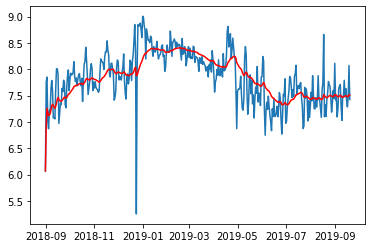

In [14]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

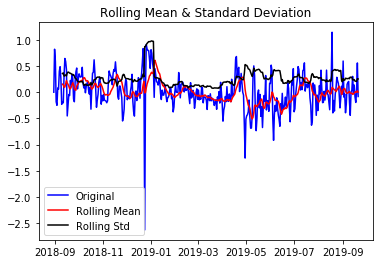

Results of Dickey-Fuller Test:
Test Statistics                 -3.806325
p-value                          0.002843
#Lags Used                      13.000000
Number of Observations Used    372.000000
Critical Value (1%)             -3.448052
Critical Value (5%)             -2.869341
Critical Value (10%)            -2.570926
dtype: float64


In [15]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

#STD is quite flat as opposed to previous experiments
# The dataset is close enough to stationary data, since it doesn't have any trend

#### We can use both transformation/tests to check whether the data is stationary and ready for forecasting
#### Next step is to shift the values into time series so that we can use it in the forecasting

In [16]:
## We have substracted the value of mean from the actual value
## Now we will apply the function shift() to shift all of those values 

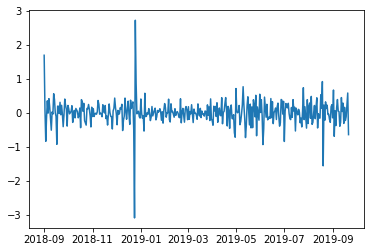

In [17]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

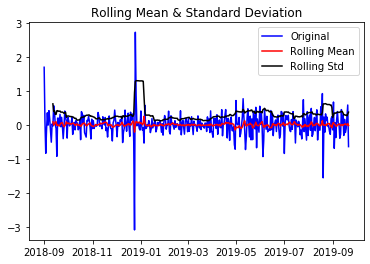

Results of Dickey-Fuller Test:
Test Statistics               -7.955090e+00
p-value                        3.052426e-12
#Lags Used                     1.200000e+01
Number of Observations Used    3.720000e+02
Critical Value (1%)           -3.448052e+00
Critical Value (5%)           -2.869341e+00
Critical Value (10%)          -2.570926e+00
dtype: float64


In [18]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)
#null hypothesis is rejected - time series is stationary

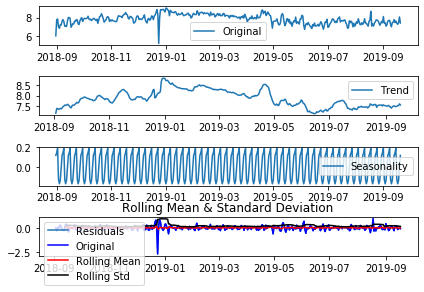

Results of Dickey-Fuller Test:
Test Statistics               -9.377158e+00
p-value                        7.116369e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.670000e+02
Critical Value (1%)           -3.448294e+00
Critical Value (5%)           -2.869448e+00
Critical Value (10%)          -2.570983e+00
dtype: float64


In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

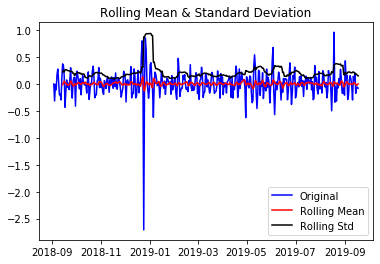

Results of Dickey-Fuller Test:
Test Statistics               -9.377158e+00
p-value                        7.116369e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.670000e+02
Critical Value (1%)           -3.448294e+00
Critical Value (5%)           -2.869448e+00
Critical Value (10%)          -2.570983e+00
dtype: float64


In [20]:
#Checking noise if it's stationary or not
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


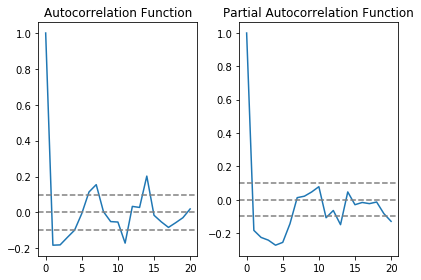

In [21]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')
#ordinary least square method

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Plotting AR model


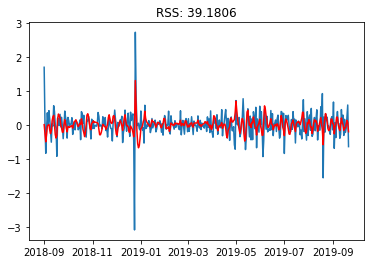

In [22]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting['sales'])**2))
print('Plotting AR model')


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Plotting MA model


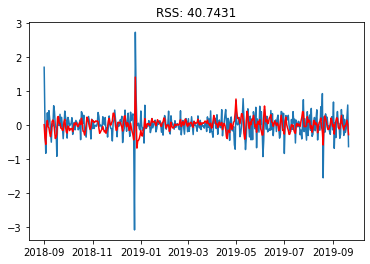

In [23]:
#MA model
model = ARIMA(indexedDataset_logScale, order=(0, 1, 2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting['sales'])**2))
print('Plotting MA model')

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 39.1806')

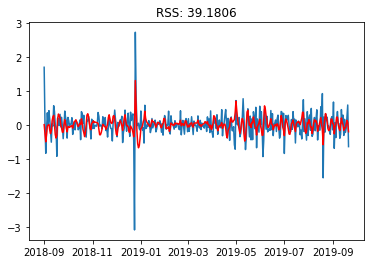

In [24]:
model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['sales'])**2))

In [25]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

transaction_date
2018-09-01    0.001649
2018-09-02   -0.253308
2018-09-03   -0.502959
2018-09-04   -0.287978
2018-09-05   -0.029689
dtype: float64


In [26]:
#Convert to cumylative sum 
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

transaction_date
2018-09-01    0.001649
2018-09-02   -0.251660
2018-09-03   -0.754619
2018-09-04   -1.042597
2018-09-05   -1.072286
dtype: float64


In [27]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['sales'].ix[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


transaction_date
2018-08-31    6.068217
2018-09-01    6.069866
2018-09-02    5.816558
2018-09-03    5.313599
2018-09-04    5.025621
dtype: float64

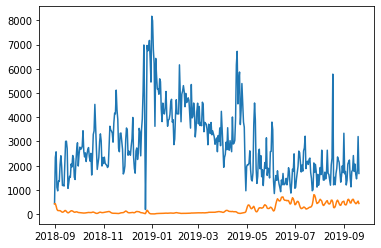

In [28]:
# Auto-Regressive Integrated Moving Average
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

#calculating exponential out of predicted values

In [29]:
indexedDataset_logScale

,sales
transaction_date,
2018-08-31,6.068217
2018-09-01,7.758167
2018-09-02,7.852882
2018-09-03,7.010321
2018-09-04,6.869939
2018-09-05,7.219840
2018-09-06,7.208970
2018-09-07,7.622684
2018-09-08,7.787424


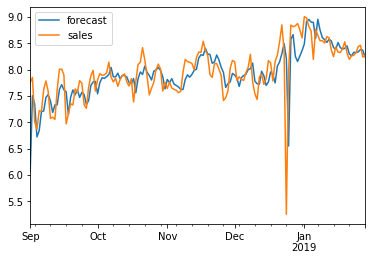

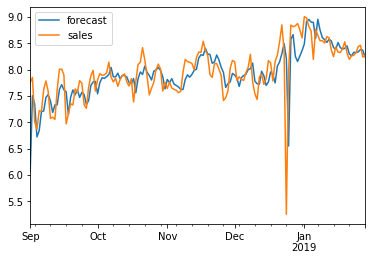

In [30]:
results_ARIMA.plot_predict(1,150)
#x=results_ARIMA.forecast(steps=)

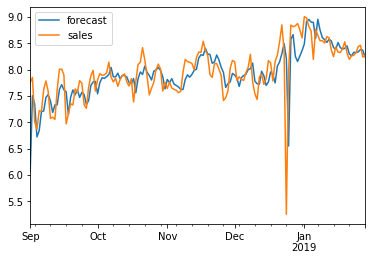

In [31]:
results_ARIMA.plot_predict(1,150)
x=results_ARIMA.forecast(steps=100)

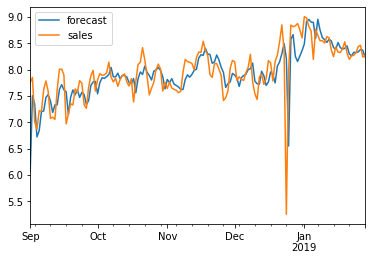

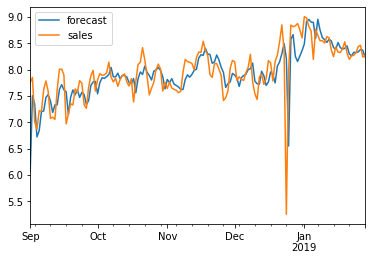

In [32]:
results_ARIMA.plot_predict(1,150)

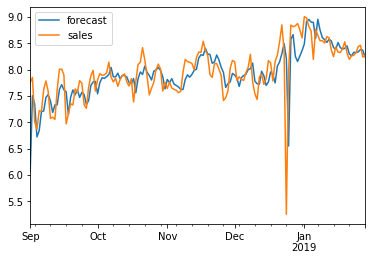

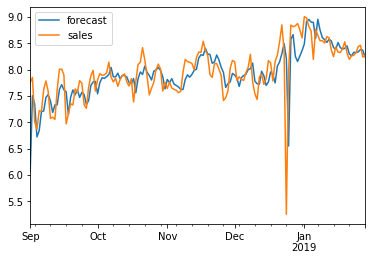

In [34]:
results_ARIMA.plot_predict(1,150)

In [35]:
print(results_ARIMA)